The notebook is mainly based on pgmpy's introductory notebooks.  You will need to install the pgmpy ("Probabilistic Graphical Models for Python") package if it is not already installed (I used: pip install pgmpy).

In [1]:
from IPython.display import Image

### Bayesian Models
We can take the example of the student model:

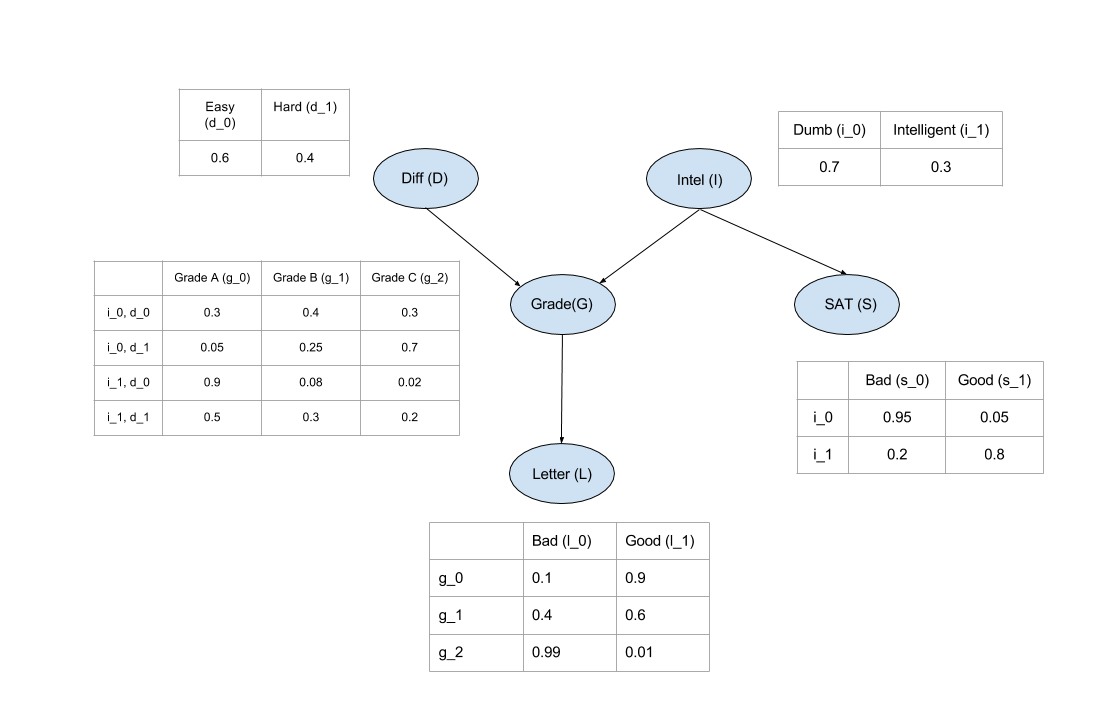

In [2]:
Image('./student_full_param.png')

In pgmpy we define the network structure and the CPDs separately and then associate them with the structure. Here's an example for defining the above model:

In [3]:
from pgmpy.models import BayesianModel
from pgmpy.factors.discrete import TabularCPD

# Defining the model structure. We can define the network by just passing a list of edges.
model = BayesianModel([('D', 'G'), ('I', 'G'), ('G', 'L'), ('I', 'S')])

# Defining individual CPDs.
cpd_d = TabularCPD(variable='D', variable_card=2, values=[[0.6, 0.4]])
cpd_i = TabularCPD(variable='I', variable_card=2, values=[[0.7, 0.3]])

# The representation of CPD in pgmpy is a bit different than the CPD shown in the above picture. In pgmpy the colums
# are the evidences and rows are the states of the variable. So the grade CPD is represented like this:
#
#    +---------+---------+---------+---------+---------+
#    | diff    | intel_0 | intel_0 | intel_1 | intel_1 |
#    +---------+---------+---------+---------+---------+
#    | intel   | diff_0  | diff_1  | diff_0  | diff_1  |
#    +---------+---------+---------+---------+---------+
#    | grade_0 | 0.3     | 0.05    | 0.9     | 0.5     |
#    +---------+---------+---------+---------+---------+
#    | grade_1 | 0.4     | 0.25    | 0.08    | 0.3     |
#    +---------+---------+---------+---------+---------+
#    | grade_2 | 0.3     | 0.7     | 0.02    | 0.2     |
#    +---------+---------+---------+---------+---------+

cpd_g = TabularCPD(variable='G', variable_card=3, 
                   values=[[0.3, 0.05, 0.9,  0.5],
                           [0.4, 0.25, 0.08, 0.3],
                           [0.3, 0.7,  0.02, 0.2]],
                  evidence=['I', 'D'],
                  evidence_card=[2, 2])

cpd_l = TabularCPD(variable='L', variable_card=2, 
                   values=[[0.1, 0.4, 0.99],
                           [0.9, 0.6, 0.01]],
                   evidence=['G'],
                   evidence_card=[3])

cpd_s = TabularCPD(variable='S', variable_card=2,
                   values=[[0.95, 0.2],
                           [0.05, 0.8]],
                   evidence=['I'],
                   evidence_card=[2])

# Associating the CPDs with the network
model.add_cpds(cpd_d, cpd_i, cpd_g, cpd_l, cpd_s)

# check_model checks for the network structure and CPDs and verifies that the CPDs are correctly 
# defined and sum to 1.
model.check_model()

True

In [4]:
# We can now call some methods on the BayesianModel object.
model.get_cpds()

[<TabularCPD representing P(D:2) at 0x52d0320L>,
 <TabularCPD representing P(I:2) at 0xb229940L>,
 <TabularCPD representing P(G:3 | I:2, D:2) at 0xb2299b0L>,
 <TabularCPD representing P(L:2 | G:3) at 0x5358908L>,
 <TabularCPD representing P(S:2 | I:2) at 0x53587b8L>]

In [5]:
print(model.get_cpds('G'))

+-----+-----+------+------+-----+
| I   | I_0 | I_0  | I_1  | I_1 |
+-----+-----+------+------+-----+
| D   | D_0 | D_1  | D_0  | D_1 |
+-----+-----+------+------+-----+
| G_0 | 0.3 | 0.05 | 0.9  | 0.5 |
+-----+-----+------+------+-----+
| G_1 | 0.4 | 0.25 | 0.08 | 0.3 |
+-----+-----+------+------+-----+
| G_2 | 0.3 | 0.7  | 0.02 | 0.2 |
+-----+-----+------+------+-----+


In [6]:
print model.predecessors('G')
print model.successors('G')

['I', 'D']
['L']


### Independencies in Bayesian Networks

Independence relationships implied by the network structure of a Bayesian Network can be categorized into 2 types:

__Local Independencies:__ Any variable in the network is independent of its non-descendents given its parents. Mathematically it can be written as: $$ (X \perp NonDesc(X) | Pa(X) $$
where $ NonDesc(X) $ is the set of variables which are not descendents of $ X $ and $ Pa(X) $ is the set of variables which are parents of $ X $.


__Global Independencies:__ For discussing global independencies in Bayesian Networks we need to look at the various network structures possible.

In [7]:
# Getting the local independencies of a variable.
print model.nodes()
for thenode in model.nodes():
    print model.local_independencies(thenode)
# Or equivalently, you could write: model.local_independencies(model.nodes())
model.local_independencies(model.nodes())

['I', 'S', 'D', 'G', 'L']
(I _|_ D)
(S _|_ D, G, L | I)
(D _|_ I, S)
(G _|_ S | I, D)
(L _|_ I, S, D | G)


(I _|_ D)
(S _|_ D, G, L | I)
(D _|_ I, S)
(G _|_ S | I, D)
(L _|_ I, S, D | G)

In [8]:
# Active trail: For any two variables A and B in a network if any change in A influences the values of B then we say
# that there is an active trail (or unblocked path) between A and B.
# In pgmpy, active_trail_nodes gives a set of nodes which are affected by any change in the node passed in the argument.
for thenode in model.nodes():
    print model.active_trail_nodes(thenode)

{'I': set(['I', 'S', 'L', 'G'])}
{'S': set(['I', 'S', 'L', 'G'])}
{'D': set(['D', 'G', 'L'])}
{'G': set(['I', 'S', 'D', 'G', 'L'])}
{'L': set(['I', 'S', 'L', 'G', 'D'])}


In [9]:
for thenode in model.nodes():
    print model.active_trail_nodes(thenode, observed='G')

{'I': set(['I', 'S', 'D'])}
{'S': set(['I', 'S', 'D'])}
{'D': set(['I', 'S', 'D'])}
{'G': set([])}
{'L': set(['L'])}


Conditional Probability 

In [10]:
from pgmpy.inference import VariableElimination
infer = VariableElimination(model)

# Marginal distribution of G
print(infer.query(['G'], evidence={})['G'])

# Conditional distribution of G given ~D, I
print(infer.query(['G'], evidence={'D': 0, 'I': 1}) ['G'])

+-----+----------+
| G   |   phi(G) |
+=====+==========+
| G_0 |   0.3620 |
+-----+----------+
| G_1 |   0.2884 |
+-----+----------+
| G_2 |   0.3496 |
+-----+----------+
+-----+----------+
| G   |   phi(G) |
+=====+==========+
| G_0 |   0.9000 |
+-----+----------+
| G_1 |   0.0800 |
+-----+----------+
| G_2 |   0.0200 |
+-----+----------+


C:\Users\dbn2\AppData\Local\Continuum\anaconda2\lib\site-packages\pgmpy\factors\discrete\DiscreteFactor.py:598: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  phi1.values = phi1.values[slice_]
C:\Users\dbn2\AppData\Local\Continuum\anaconda2\lib\site-packages\pgmpy\factors\discrete\DiscreteFactor.py:586: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  phi.values = phi.values[slice_]


####  Predicting values for new data points

In [11]:
# Most likely value (marginal)
print infer.map_query(['G'], evidence={})

# Most likely value (conditional on ~D, I)
print infer.map_query(['G'], evidence={'D': 0, 'I': 1})

{'G': 0}
{'G': 0}


### Practice #1: 

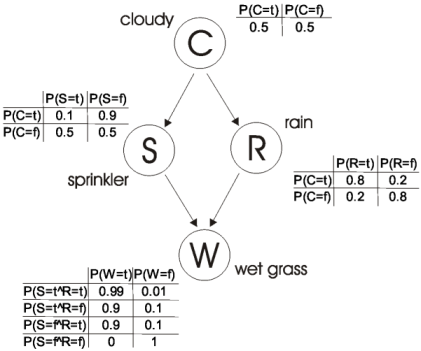

In [12]:
Image('./Cloud.png')

#### Part 1: Build the Bayesian model and add all the CPDs.  Print out all the local independencies. 

In [13]:
model2 = BayesianModel([('C', 'S'), ('C', 'R'), ('S', 'W'), ('R', 'W')])

# Defining individual CPDs. Notice that I had to rearrange the values to make 1 correspond to t, and 0 correspond to f.
cpd_c = TabularCPD(variable='C', variable_card=2, values=[[0.5, 0.5]])
cpd_s = TabularCPD(variable='S', variable_card=2,
        values=[[0.5, 0.9],
                [0.5, 0.1]],
        evidence=['C'],evidence_card=[2])
cpd_r = TabularCPD(variable='R', variable_card=2,
        values=[[0.8, 0.2],
                [0.2, 0.8]],
        evidence=['C'],evidence_card=[2])
cpd_w = TabularCPD(variable='W', variable_card=2, 
        values=[[1, 0.1, 0.1, 0.01],
                [0, 0.9, 0.9, 0.99]],
        evidence=['S','R'],evidence_card=[2,2])

model2.add_cpds(cpd_c, cpd_s, cpd_r, cpd_w)

print model2.check_model()

# ALWAYS CHECK THE CPDs FOR CORRECTNESS!
for thenode in model2.nodes():
  print model2.get_cpds(thenode)

print model2.local_independencies(model2.nodes())

True
+-----+-----+
| C_0 | 0.5 |
+-----+-----+
| C_1 | 0.5 |
+-----+-----+
+-----+-----+-----+
| C   | C_0 | C_1 |
+-----+-----+-----+
| R_0 | 0.8 | 0.2 |
+-----+-----+-----+
| R_1 | 0.2 | 0.8 |
+-----+-----+-----+
+-----+-----+-----+
| C   | C_0 | C_1 |
+-----+-----+-----+
| S_0 | 0.5 | 0.9 |
+-----+-----+-----+
| S_1 | 0.5 | 0.1 |
+-----+-----+-----+
+-----+-----+-----+-----+------+
| S   | S_0 | S_0 | S_1 | S_1  |
+-----+-----+-----+-----+------+
| R   | R_0 | R_1 | R_0 | R_1  |
+-----+-----+-----+-----+------+
| W_0 | 1.0 | 0.1 | 0.1 | 0.01 |
+-----+-----+-----+-----+------+
| W_1 | 0.0 | 0.9 | 0.9 | 0.99 |
+-----+-----+-----+-----+------+
(R _|_ S | C)
(S _|_ R | C)
(W _|_ C | S, R)


#### Part 2. Get P(W), P(W|C=f, S=t, R=t), and P(W|C=f,S=f).  Predict the most likely value of W in each case.

In [14]:
infer2 = VariableElimination(model2)

print(infer2.query(['W']) ['W'])
print(infer2.map_query(['W']))

print infer2.query(['W'], evidence={'C': 0, 'S': 1, 'R': 1})['W']
print infer2.map_query(['W'], evidence={'C': 0, 'S': 1, 'R': 1})

print infer2.query(['W'], evidence={'C': 0, 'S': 0})['W']
print infer2.map_query(['W'], evidence={'C': 0, 'S': 0})

+-----+----------+
| W   |   phi(W) |
+=====+==========+
| W_0 |   0.3529 |
+-----+----------+
| W_1 |   0.6471 |
+-----+----------+
{'W': 1}
+-----+----------+
| W   |   phi(W) |
+=====+==========+
| W_0 |   0.0100 |
+-----+----------+
| W_1 |   0.9900 |
+-----+----------+
{'W': 1}
+-----+----------+
| W   |   phi(W) |
+=====+==========+
| W_0 |   0.8200 |
+-----+----------+
| W_1 |   0.1800 |
+-----+----------+
{'W': 0}


## Learning from Data

This section will be about obtaining a Bayesian network, given a set of sample data. Learning a Bayesian network can be split into two problems:

 **Parameter learning:** Given a set of data records and a DAG that captures the dependencies between the variables, estimate the (conditional) probability distributions of the individual variables.
 
 **Structure learning:** Given a set of data records, estimate a DAG that captures the dependencies between the variables.
 
We will illustrate how parameter learning and structure learning can be done with pgmpy. Currently, the library supports:

 - Parameter learning for *discrete* nodes:
   - Maximum Likelihood Estimation
   - Bayesian Estimation

- Structure learning for *discrete*, *fully observed* networks:
   - Score-based structure estimation (BIC/BDeu/K2 score; exhaustive search, hill climb/tabu search)
   - Constraint-based structure estimation (PC)


### (1) Parameter Learning

Suppose we have the following data:

In [16]:
import pandas as pd
data = pd.DataFrame(data={'fruit': ["banana", "apple", "banana", "apple", "banana","apple", "banana", 
                                    "apple", "apple", "apple", "banana", "banana", "apple", "banana",], 
                          'tasty': ["yes", "no", "yes", "yes", "yes", "yes", "yes", 
                                    "yes", "yes", "yes", "yes", "no", "no", "no"], 
                          'size': ["large", "large", "large", "small", "large", "large", "large",
                                    "small", "large", "large", "large", "large", "small", "small"]})
data

,fruit,size,tasty
0,banana,large,yes
1,apple,large,no
2,banana,large,yes
3,apple,small,yes
4,banana,large,yes
5,apple,large,yes
6,banana,large,yes
7,apple,small,yes
8,apple,large,yes
9,apple,large,yes


We know that the variables are related as follows:

In [17]:
from pgmpy.models import BayesianModel
model = BayesianModel([('fruit', 'tasty'), ('size', 'tasty')])  # fruit -> tasty <- size

Parameter learning is the task of estimating the values of the conditional probability distributions (CPDs), for the variables `fruit`, `size`, and `tasty`. 

#### State counts

To make sense of the given data, we can start by counting how often each state of the variable occurs. If the variable is dependent on parents, the counts are done conditionally on the parents states, i.e., separately for each parent configuration:

In [18]:
from pgmpy.estimators import ParameterEstimator
pe = ParameterEstimator(model, data)
print(pe.state_counts('fruit'))  # unconditional
print "\n"
print(pe.state_counts('tasty'))  # conditional on fruit and size

        fruit
apple       7
banana      7


fruit apple       banana      
size  large small  large small
tasty                         
no      1.0   1.0    1.0   1.0
yes     3.0   2.0    5.0   0.0


#### Maximum Likelihood Estimation

A natural estimate for the CPDs is to simply use the *relative frequencies* with which the variable states have occured. We observed `7 apples` among a total of `14 fruits`, so we might guess that about `50%` of `fruits` are `apples`.

This approach is *Maximum Likelihood Estimation (MLE)*. According to MLE, we should fill the CPDs in such a way, that $P(\text{data}\:|\:\text{model})$ is maximal. This is achieved when using the *relative frequencies*.

In [18]:
from pgmpy.estimators import MaximumLikelihoodEstimator
mle = MaximumLikelihoodEstimator(model, data)
print(mle.estimate_cpd('fruit'))  # unconditional
print(mle.estimate_cpd('tasty'))  # conditional

+---------------+-----+
| fruit(apple)  | 0.5 |
+---------------+-----+
| fruit(banana) | 0.5 |
+---------------+-----+
+------------+--------------+--------------------+---------------------+---------------+
| fruit      | fruit(apple) | fruit(apple)       | fruit(banana)       | fruit(banana) |
+------------+--------------+--------------------+---------------------+---------------+
| size       | size(large)  | size(small)        | size(large)         | size(small)   |
+------------+--------------+--------------------+---------------------+---------------+
| tasty(no)  | 0.25         | 0.3333333333333333 | 0.16666666666666666 | 1.0           |
+------------+--------------+--------------------+---------------------+---------------+
| tasty(yes) | 0.75         | 0.6666666666666666 | 0.8333333333333334  | 0.0           |
+------------+--------------+--------------------+---------------------+---------------+


While very straightforward, the ML estimator has the problem of *overfitting* to the data. In above CPD, the probability of a large banana being tasty is estimated at `0.833`, because `5` out of `6` observed large bananas were tasty. Fine. But note that the probability of a small banana being tasty is estimated at `0.0`, because we  observed only one small banana and it happened to be not tasty. But that should hardly make us certain that small bananas aren't tasty! We simply do not have enough observations to rely on the observed frequencies. If the observed data is not representative for the underlying distribution, ML estimations will be extremly far off. 

When estimating parameters for Bayesian networks, lack of data is a frequent problem. Even if the total sample size is very large, the fact that state counts are done conditionally for each parents configuration causes immense fragmentation. If a variable has 3 parents that can each take 10 states, then state counts will be done seperately for `10^3 = 1000` parents configurations. This makes MLE very fragile and unstable for learning Bayesian Network parameters. A way to mitigate MLE's overfitting is *Bayesian Parameter Estimation*.

#### Bayesian Parameter Estimation

The Bayesian Parameter Estimator starts with already existing prior CPDs, that express our beliefs about the variables *before* the data was observed. Those "priors" are then updated, using the state counts from the observed data.

One can think of the priors as consisting of *pseudo state counts*, that are added to the actual counts before normalization.  Unless one wants to encode specific beliefs about the distributions of the variables, one commonly chooses uniform priors, i.e. assume that all states are equally likely.

A very simple prior is the so-called *K2* prior, which simply adds `1` to the count of every single state.  A somewhat more sensible choice of prior is *BDeu* (Bayesian Dirichlet equivalent uniform prior). For BDeu we need to specify an *equivalent sample size* `N` and then the pseudo-counts are the equivalent of having observed `N` uniform samples of each variable (and each parent configuration). In pgmpy:

##### Parameters
----------
prior_type: 'dirichlet', 'BDeu', or 'K2'

string indicting which type of prior to use for the model parameters.
            
- If 'prior_type' is 'dirichlet', the following must be provided:

'pseudo_counts' = dirichlet hyperparameters; a dict containing, for each variable, a list with a "virtual" count for each variable state, that is added to the state counts.(lexicographic ordering of states assumed)
            
- If 'prior_type' is 'BDeu', then an 'equivalent_sample_size' must be specified instead of 'pseudo_counts'. This is equivalent to 'prior_type=dirichlet' and using uniform 'pseudo_counts' of `equivalent_sample_size/(node_cardinality*np.pro(parents_cardinalities))` for each node.
'equivalent_sample_size' can either be a numerical value or a dict that specifies the size for each variable seperately.

- A prior_type of 'K2' is a shorthand for 'dirichlet' + setting every pseudo_count to 1, regardless of the cardinality of the variable.

##### Returns
-------
parameters: list

List of TabularCPDs, one for each variable of the model


In [19]:
from pgmpy.estimators import BayesianEstimator
est = BayesianEstimator(model, data)

print(est.estimate_cpd('tasty', prior_type='BDeu', equivalent_sample_size=10))
print
print(est.estimate_cpd('tasty', prior_type='K2'))

+------------+---------------------+--------------------+--------------------+---------------------+
| fruit      | fruit(apple)        | fruit(apple)       | fruit(banana)      | fruit(banana)       |
+------------+---------------------+--------------------+--------------------+---------------------+
| size       | size(large)         | size(small)        | size(large)        | size(small)         |
+------------+---------------------+--------------------+--------------------+---------------------+
| tasty(no)  | 0.34615384615384615 | 0.4090909090909091 | 0.2647058823529412 | 0.6428571428571429  |
+------------+---------------------+--------------------+--------------------+---------------------+
| tasty(yes) | 0.6538461538461539  | 0.5909090909090909 | 0.7352941176470589 | 0.35714285714285715 |
+------------+---------------------+--------------------+--------------------+---------------------+

+------------+--------------------+--------------+---------------+--------------------+
| 

In [19]:
import numpy as np
import pandas as pd
from pgmpy.models import BayesianModel
from pgmpy.estimators import BayesianEstimator

np.random.seed(100)
raw_data = np.random.randint(low=0, high=2, size=(1000, 3))
data = pd.DataFrame(raw_data, columns=['D', 'I', 'G'])
data.D=data.I+data.G
print(data.head())

   D  I  G
0  1  0  1
1  2  1  1
2  0  0  0
3  1  0  1
4  0  0  0


In [20]:
model = BayesianModel([("I","D"),("G","D")])
model.fit(data, estimator=BayesianEstimator, prior_type='K2')
for cpd in model.get_cpds():
    print("CPD of {variable}:".format(variable=cpd.variable))
    print(cpd)

CPD of I:
+------+----------+
| I(0) | 0.500998 |
+------+----------+
| I(1) | 0.499002 |
+------+----------+
CPD of D:
+------+-----------------------+----------------------+----------------------+---------------------+
| G    | G(0)                  | G(0)                 | G(1)                 | G(1)                |
+------+-----------------------+----------------------+----------------------+---------------------+
| I    | I(0)                  | I(1)                 | I(0)                 | I(1)                |
+------+-----------------------+----------------------+----------------------+---------------------+
| D(0) | 0.9924528301886792    | 0.003703703703703704 | 0.004132231404958678 | 0.00425531914893617 |
+------+-----------------------+----------------------+----------------------+---------------------+
| D(1) | 0.0037735849056603774 | 0.9925925925925926   | 0.9917355371900827   | 0.00425531914893617 |
+------+-----------------------+----------------------+-----------------

In [21]:
print data.head()
model.predict(data.loc[:4,["I","G"]])

   D  I  G
0  1  0  1
1  2  1  1
2  0  0  0
3  1  0  1
4  0  0  0


,D
0,1
1,2
2,0
3,1
4,0


### (2) Structure Learning

To learn model structure (a DAG) from a data set, there are two broad techniques:

 - score-based structure learning
 - constraint-based structure learning

We briefly discuss these approaches and give examples.

### Score-based Structure Learning

This approach construes model selection as an optimization task. It has two building blocks:

- A _scoring function_ $s_D\colon M \to \mathbb R$ that maps models to a numerical score, based on how well they fit to a given data set $D$.
- A _search strategy_ to traverse the search space of possible models $M$ and select a model with optimal score.


#### Scoring functions

Commonly used scores to measure the fit between model and data are _Bayesian Dirichlet scores_ such as *BDeu* or *K2* and the _Bayesian Information Criterion_ (BIC, also called MDL).

Bic: https://en.wikipedia.org/wiki/Bayesian_information_criterion

In [23]:
import pandas as pd
import numpy as np
from pgmpy.estimators import BdeuScore, K2Score, BicScore
from pgmpy.models import BayesianModel

# create random data sample with 3 variables, where Z is dependent on X, Y:
data = pd.DataFrame(np.random.randint(0, 4, size=(5000, 2)), columns=list('XY'))
data['Z'] = data['X'] + data['Y']

bdeu = BdeuScore(data, equivalent_sample_size=5)
k2 = K2Score(data)
bic = BicScore(data)

model0 = BayesianModel([]) # all independent
model0.add_nodes_from(['X','Y','Z'])
model1 = BayesianModel([('X', 'Z'), ('Y', 'Z')])  # X -> Z <- Y
model2 = BayesianModel([('X', 'Z'), ('X', 'Y')])  # Y <- X -> Z

# In each case, the best model (model1) has the least negative score
print "BDEU scores"
print "Model 0:",bdeu.score(model0),"\nModel 1:",bdeu.score(model1),"\nModel 2:",bdeu.score(model2)
print "\nK2 scores"
print "Model 0:",k2.score(model0),"\nModel 1:",k2.score(model1),"\nModel 2:",k2.score(model2)
print "\nBIC scores"
print "Model 0:",bic.score(model0),"\nModel 1:",bic.score(model1),"\nModel 2:",bic.score(model2)

BDEU scores
Model 0: -23105.1982088 
Model 1: -13939.9461501 
Model 2: -20901.6700546

K2 scores
Model 0: -23105.0085826 
Model 1: -14330.7433918 
Model 2: -20928.5094966

BIC scores
Model 0: -23113.417855081014 
Model 1: -14295.98666575721 
Model 2: -20945.715010828048


In [24]:
# These should add to the BDEU score of model 1
print(bdeu.local_score('X', parents=[]))
print(bdeu.local_score('Y', parents=[]))
print(bdeu.local_score('Z', parents=['X', 'Y']))

print

# And these should add to the BDEU score of model 2
print(bdeu.local_score('X', parents=[]))
print(bdeu.local_score('Y', parents=['X']))
print(bdeu.local_score('Z', parents=['X']))

-6940.93961263
-6941.88692591
-57.1196115533

-6940.93961263
-6969.48543548
-6991.24500647


#### Search strategies

The search space of DAGs is super-exponential in the number of variables and the above scoring functions allow for local maxima. The first property makes exhaustive search intractable for all but very small networks, while the second property can prevent efficient local optimization algorithms from always finding the optimal structure. Thus, identifiying the ideal structure is often not tractable. Nevertheless, heuristic search strategies often yield good results.

If only few nodes are involved (read: less than 5), `ExhaustiveSearch` can be used to compute the score for every DAG and returns the best-scoring one.

In [25]:
from pgmpy.estimators import ExhaustiveSearch

# Note: exhaustive search will be terribly expensive for more than a few variables
es = ExhaustiveSearch(data, scoring_method=bic)
best_model = es.estimate()
print(best_model.edges())

print("\nAll DAGs by score:")
for score, dag in reversed(es.all_scores()):
    print(score, dag.edges())

[('Y', 'Z'), ('X', 'Z')]

All DAGs by score:
(-14295.98666575721, [('Y', 'Z'), ('X', 'Z')])
(-14327.684577930311, [('Y', 'X'), ('Z', 'Y'), ('Z', 'X')])
(-14327.684577930311, [('X', 'Y'), ('Z', 'Y'), ('Z', 'X')])
(-14327.684577930313, [('Y', 'X'), ('Y', 'Z'), ('Z', 'X')])
(-14327.684577930313, [('Y', 'X'), ('Y', 'Z'), ('X', 'Z')])
(-14327.684577930315, [('X', 'Y'), ('X', 'Z'), ('Z', 'Y')])
(-14327.684577930315, [('Y', 'Z'), ('X', 'Y'), ('X', 'Z')])
(-16527.085334356383, [('X', 'Y'), ('Z', 'Y')])
(-16528.033211315378, [('Y', 'X'), ('Z', 'X')])
(-18713.668465269875, [('Z', 'Y'), ('Z', 'X')])
(-18713.668465269875, [('Y', 'Z'), ('Z', 'X')])
(-18713.668465269875, [('X', 'Z'), ('Z', 'Y')])
(-20913.069221695947, [('Z', 'Y')])
(-20913.069221695947, [('Y', 'Z')])
(-20914.017098654942, [('Z', 'X')])
(-20914.017098654942, [('X', 'Z')])
(-20944.76713386905, [('Y', 'X'), ('Z', 'Y')])
(-20944.76713386905, [('Y', 'X'), ('Y', 'Z')])
(-20944.767133869052, [('Y', 'Z'), ('X', 'Y')])
(-20945.715010828048, 

Once more nodes are involved, one needs to switch to heuristic search. `HillClimbSearch` implements a greedy local search that starts from the DAG `start` (default: disconnected DAG) and proceeds by iteratively performing single-edge manipulations that maximally increase the score. The search terminates once a local maximum is found.

In [26]:
from pgmpy.estimators import HillClimbSearch

# create some random data with dependencies
np.random.seed(30)
data = pd.DataFrame(np.random.randint(0, 3, size=(2500, 8)), columns=list('ABCDEFGH'))
data['A'] += data['B'] + data['C']
data['H'] = data['G'] - data['A']

hc = HillClimbSearch(data, scoring_method=BicScore(data))
best_model = hc.estimate()
print(best_model.edges())

# Note: it doesn't always find the "correct" network.  To see this, try a different random seed.

[('A', 'H'), ('C', 'A'), ('B', 'A'), ('G', 'H')]


### Practice #2

In [27]:
import pandas as pd
from sklearn.model_selection import train_test_split

# All variables except the target variable (manhattan) are in the range 1..max_value.
# But pgmpy needs to work with small integers 0..max_value-1, so we subtract 1 from all columns except manhattan.
data = pd.read_csv("NYC_taxi_sample.csv")-[0,1,1,1,1]
print data.head()
train,test=train_test_split(data,random_state=999,test_size=0.2)

   manhattan  tip  dist  speed  pass
0          0    0     0      0     0
1          0    2     4      5     0
2          0    0     5      3     1
3          1    1     1      1     0
4          0    3     0      0     0


#### Part 1. Learn the Bayes Net structure.  You can choose your favorite search method and scoring function.

In [28]:
hc = HillClimbSearch(train, scoring_method=BicScore(train))
best_model = hc.estimate()
print(best_model.edges())

[('dist', 'speed'), ('manhattan', 'tip'), ('manhattan', 'pass'), ('speed', 'manhattan'), ('pass', 'tip')]


#### Part 2. Learn the model parameters assuming the structure you learned in Part 1.  Also print out all of the local independencies.

In [29]:
best_model.fit(train, estimator=BayesianEstimator, prior_type='K2')
for cpd in best_model.get_cpds():
    print("CPD of {variable}:".format(variable=cpd.variable))
    print(cpd)
print best_model.local_independencies(best_model.nodes())

CPD of tip:
+-----------+---------------------+----------------------+--------------+---------------------+----------------------+---------------------+---------------------+----------------------+
| manhattan | manhattan(0)        | manhattan(0)         | manhattan(0) | manhattan(0)        | manhattan(1)         | manhattan(1)        | manhattan(1)        | manhattan(1)         |
+-----------+---------------------+----------------------+--------------+---------------------+----------------------+---------------------+---------------------+----------------------+
| pass      | pass(0)             | pass(1)              | pass(2)      | pass(3)             | pass(0)              | pass(1)             | pass(2)             | pass(3)              |
+-----------+---------------------+----------------------+--------------+---------------------+----------------------+---------------------+---------------------+----------------------+
| tip(0)    | 0.6034704370179949  | 0.5017543859649123   |

#### Part 3. Report the IS and OS classification accuracy for "Manhattan"

In [31]:
from collections import defaultdict
def temp_predict(model,data):
    missing_variables = list(set(model.nodes()) - set(data.columns))
    pred_values = defaultdict(list)
    model_inference = VariableElimination(model)
    for index, data_point in data.iterrows():
        states_dict = model_inference.map_query(variables=missing_variables, evidence=data_point.astype(int).to_dict())
        for k, v in states_dict.items():
            pred_values[k].append(v)
    return pd.DataFrame(pred_values, index=data.index)

train_x = train.loc[:,"tip":"pass"]
#predicted_train = best_model.predict(train_x) should work, but is buggy in the current version
predicted_train = temp_predict(best_model, train_x)
print "In sample:",(train.loc[:,'manhattan']==predicted_train['manhattan']).mean()

test_x = test.loc[:,"tip":"pass"]
#predicted_test = best_model.predict(test_x) should work, but is buggy in the current version
predicted_test = temp_predict(best_model, test_x)
print "Out of sample:",(test.loc[:,'manhattan']==predicted_test['manhattan']).mean()

In sample: 0.722495894909688
Out of sample: 0.6951219512195121


### Constraint-based Structure Learning

A different approach to build a DAG from data, attempting to correctly capture the directionality of causal relationships, is this:

1. Identify independencies in the data set using hypothesis tests 
2. Construct a DAG according to identified independencies

#### (Conditional) Independence Tests

Independencies in the data can be identified using $\chi^2$ conditional independence tests. To this end, constraint-based estimators in pgmpy have a `test_conditional_independence(X, Y, Zs)`-method, that performs a hypothesis test on the data sample. It allows to check if `X` is independent from `Y` given a set of variables `Zs`:

In [32]:
from pgmpy.estimators import ConstraintBasedEstimator

data = pd.DataFrame(np.random.randint(0, 3, size=(2500, 8)), columns=list('ABCDEFGH'))
data['A'] += data['B'] + data['C']
data['H'] = data['G'] - data['A']
data['E'] *= data['F']

est = ConstraintBasedEstimator(data)

print(est.test_conditional_independence('B', 'C'))          # independent
print(est.test_conditional_independence('B', 'H'))          # dependent
print(est.test_conditional_independence('B', 'E'))          # independent
print(est.test_conditional_independence('B', 'H', ['A']))   # independent
print(est.test_conditional_independence('A', 'G'))          # independent
print(est.test_conditional_independence('A', 'G',  ['H']))  # dependent

(3.367033024384047, 0.9092606970343292, True)
(724.0979218756389, 6.3621077371991925e-136, True)
(1.3953018788864788, 0.9997331153514195, True)
(15.749678507382336, 0.9999734457458261, True)
(12.385570047777863, 0.9021659990993756, True)
(4642.999999999999, 0.0, True)


`test_conditional_independence()` returns a triple `(chi^2, p_value, sufficient_data)`, consisting of the computed $\chi^2$ test statistic, the `p_value` of the test, and a flag that indicates if the sample size was sufficient. The `p_value` is the probability of observing the computed $\chi^2$ statistic or a higher $\chi^2$ value, given the null hypothesis that X and Y are independent given Zs. 

This can be used to make independence judgements, at a given level of significance:

p-values less than the chosen significance level $\alpha$ reject the null hypothesis and conclude that X and Y are conditionally dependent given Zs.  p-values greater than or equal to $\alpha$ fail to reject the null hypothesis, from which we will conclude that X and Y are conditionally independent.

In [33]:
def is_independent(X, Y, Zs=[], significance_level=0.05):
    return est.test_conditional_independence(X, Y, Zs)[1] >= significance_level
print(is_independent('B', 'C'))
print(is_independent('B', 'H'))
print(is_independent('B', 'E'))
print(is_independent('B', 'H', ['A']))
print(is_independent('A', 'G'))
print(is_independent('A', 'G', ['H']))

True
False
True
True
True
False


#### DAG (pattern) construction

#### PC Algorithm for causal direction

With a method for independence testing at hand, we can construct a DAG from the data set in three steps:

*1. Construct an undirected skeleton - `estimate_skeleton()`

*2. Orient compelled edges to obtain partially directed acyclic graph (PDAG; I-equivalence class of DAGs) - `skeleton_to_pdag()`

Steps 1 and 2 form the PC algorithm. PDAGs are `DirectedGraph`s, that may contain bidirectional edges, to indicate that the orientation for the edge is not determined.

####  The following step orients any remaining edges, essentially at random, but in a way which is consistent with the edge directions produced by PC.  This is useful if we want to use the learned structure to perform inference, but we should not make any assumptions re. causality from the edges directed in the last step.

 *3. Extend DAG pattern to a DAG by orienting the remaining edges in some consistent way - `pdag_to_dag()`


In [34]:
skel, separating_sets = est.estimate_skeleton(significance_level=0.01)
print("Undirected edges: ", skel.edges())

pdag = est.skeleton_to_pdag(skel, separating_sets)
print("PDAG edges:       ", pdag.edges())

model = est.pdag_to_dag(pdag)
print("DAG edges:        ", model.edges())

('Undirected edges: ', [('A', 'C'), ('A', 'B'), ('A', 'H'), ('E', 'F'), ('G', 'H')])
('PDAG edges:       ', [('A', 'H'), ('C', 'A'), ('B', 'A'), ('E', 'F'), ('G', 'H'), ('F', 'E')])
('DAG edges:        ', [('A', 'H'), ('C', 'A'), ('B', 'A'), ('G', 'H'), ('F', 'E')])


Note that the last step randomly oriented the E<-->F edge.  The other edges were oriented correctly by the PC algorithm.

In [35]:
# Taxi data example

data = pd.read_csv("NYC_taxi_sample.csv")
est = ConstraintBasedEstimator(data)
skel, separating_sets = est.estimate_skeleton(significance_level=0.01)
print("Undirected edges: ", skel.edges())

pdag = est.skeleton_to_pdag(skel, separating_sets)
print("PDAG edges:       ", pdag.edges())

model = est.pdag_to_dag(pdag)
print("DAG edges:        ", model.edges())

('Undirected edges: ', [('tip', 'pass'), ('dist', 'speed'), ('dist', 'manhattan'), ('manhattan', 'speed')])
('PDAG edges:       ', [('dist', 'speed'), ('dist', 'manhattan'), ('tip', 'pass'), ('manhattan', 'speed'), ('manhattan', 'dist'), ('speed', 'dist'), ('speed', 'manhattan'), ('pass', 'tip')])
('DAG edges:        ', [('manhattan', 'dist'), ('speed', 'dist'), ('speed', 'manhattan'), ('pass', 'tip')])


In this case the PC algorithm identified four edges (tip<-->pass and manhattan/speed/dist) but was not able to infer the causal direction of any of the four.  The third step just orients all four at random, avoiding directed cycles.